## <center> `Spam SMS Detection` </center>

`Dataset:`
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

`Objective:`
Build an AI model that can classify SMS messages as spam or legitimate. Use techniques like TF-IDF or word embeddings with classifiers like Naive Bayes, Logistic Regression, or Support Vector Machines to identify spam messages


<a class="anchor" id="0.1"></a>
# **Table of Contents** 

1.	[Loading Data](#1)
1.	[Data Preparation](#2)
1.	[Exploratory Data Analysis](#3)
1.	[Balancing Data](#4)
1.  [Train/Test Splitting](#5)
1.  [Model Building](#6)
2.  [Model Evaluation](#7)
1.	[Inference](#8)
1.	[Deployment](#9)
1.	[Reference](#10)


## Loading Data
<a class="anchor" id="1"></a>
[Table of Contents](#0.1)

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import joblib
import warnings #ignore warning
warnings.filterwarnings("ignore")

In [2]:
# Define file path
filepath ="D://Portfolio//Internship//AFAME//Project details//Spam SMS Detection//spam.csv"
# Read the CSV file into a DataFrame with specified encoding
data = pd.read_csv(filepath, encoding='latin1')
# Display the first few rows of the DataFrame
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## Data Preparation
<a class="anchor" id="2"></a>
[Table of Contents](#0.1)

In [4]:
# removing excess unnecessary column 
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data.rename(columns={'v1': 'Class', 'v2': 'Text'}, inplace=True)

In [6]:
data['Class'] = data['Class'].map({'ham':0, 'spam':1})
data.head()

,Class,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# Checking null values
data.isnull().sum()

Class    0
Text     0
dtype: int64

In [8]:
data.duplicated().sum()

403

We are retaining the duplicate values as they are crucial for our task of identifying spam SMS messages.

In [9]:
# Viewing values in 'v1' column
data['Class'].value_counts()

Class
0    4825
1     747
Name: count, dtype: int64

In [10]:
data.groupby('Class').describe()

Text                                                               
      count unique                                                top freq
Class                                                                     
0      4825   4516                             Sorry, I'll call later   30
1       747    653  Please call our customer service representativ...    4

In [11]:
# Viewing the imbalanced rate
747/4825

0.15481865284974095

In [12]:
# Viewing unique values in 'v2'
data['Text'].nunique()

5169

## Exploratory Data Analysis
<a class="anchor" id="3"></a>
[Table of Contents](#0.1)

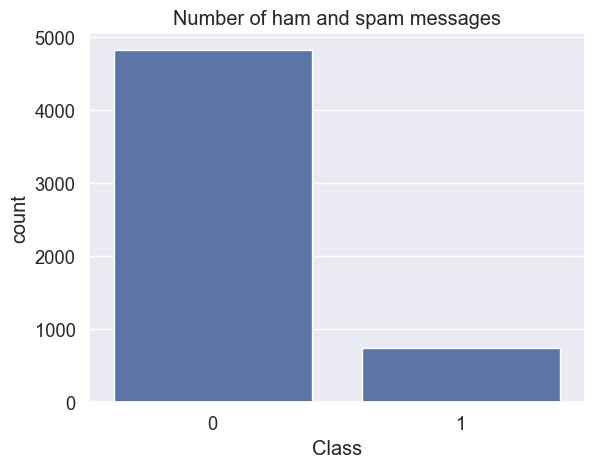

In [13]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(data=data, x= 'Class').set_title("Number of ham and spam messages")
plt.show()

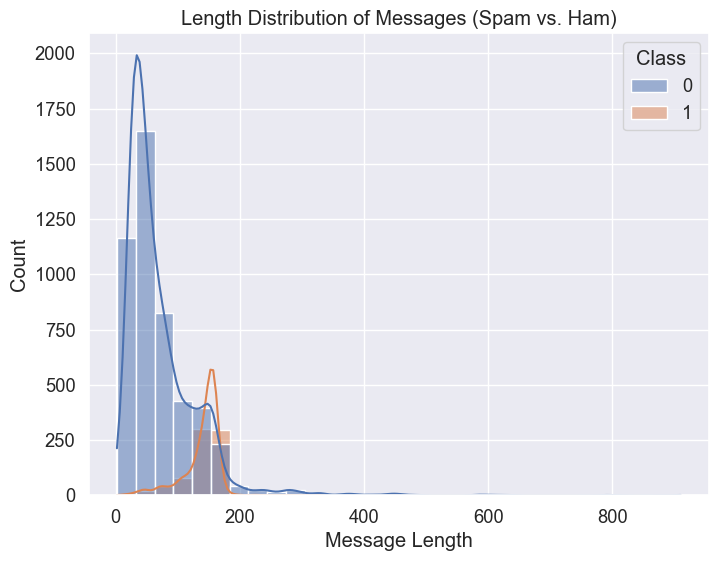

In [14]:
# Plot the distribution of message lengths
plt.figure(figsize=(8, 6))
sns.histplot(x=data['Text'].str.len(), bins=30, hue=data['Class'], kde=True)
plt.title('Length Distribution of Messages (Spam vs. Ham)')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

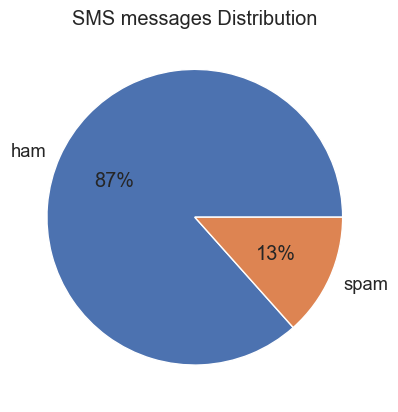

In [15]:
sms = pd.value_counts(data["Class"], sort=True)
sms.plot(kind="pie", labels=["ham", "spam"], autopct="%1.0f%%")

plt.title("SMS messages Distribution")
plt.ylabel("")
plt.show()

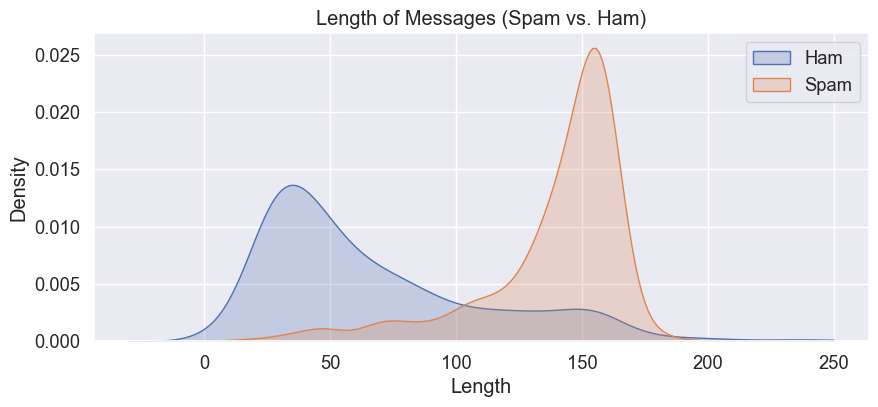

In [16]:
# Calculate lengths of messages directly in the plotting function
_, ax = plt.subplots(figsize=(10, 4))
sns.kdeplot(data.loc[data.Class == 0, 'Text'].str.len(), shade=True, label='Ham', clip=(-50, 250))
sns.kdeplot(data.loc[data.Class == 1, 'Text'].str.len(), shade=True, label='Spam', clip=(-50, 250))

# Set axis labels and title
ax.set(
    xlabel='Length',
    ylabel='Density',
    title='Length of Messages (Spam vs. Ham)'
)
ax.legend(loc='upper right')

# Show plot
plt.show()

## Balancing data
<a class="anchor" id="4"></a>
[Table of Contents](#0.1)

In [17]:
data_spam = data[data['Class']==1]
data_spam.shape

(747, 2)

In [18]:
data_ham = data[data['Class']==0]
data_ham.shape

(4825, 2)

In [19]:
data_ham_downsampled = data_ham.sample(data_spam.shape[0])
data_ham_downsampled.shape

(747, 2)

In [20]:
data_balanced = pd.concat([data_spam,data_ham_downsampled])
data_balanced.shape

(1494, 2)

In [21]:
data_balanced['Class'].value_counts()

Class
1    747
0    747
Name: count, dtype: int64

## Training/Test Split
<a class="anchor" id="5"></a>
[Table of Contents](#0.1)

In [22]:
X = data_balanced['Text']
y = data_balanced['Class']

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y)

print(f'Training data: {len(X_train)}, {len(y_train)}')
print(f'Testing data: {len(X_test)}, {len(y_test)}') 

Training data: 1045, 1045
Testing data: 449, 449


## Model Building
<a class="anchor" id="6"></a>
[Table of Contents](#0.1)

In [24]:
%%time
bert_preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3') # loading Bert Preprocessor
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4') # Loading Bert Encoder

CPU times: total: 9.08 s
Wall time: 13.4 s


In [25]:
%%time
# Functional Bert layers
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'Inputs')
encoder_inputs = bert_preprocessor(text_input)
embbed = bert_encoder(encoder_inputs)
# Neural Network layers
dropout = tf.keras.layers.Dropout(0.1, name = 'Dropout')(embbed['pooled_output'])
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'Dense')(dropout)

# creating final model
model = tf.keras.Model(inputs = [text_input], outputs = [outputs])

CPU times: total: 359 ms
Wall time: 552 ms


In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inputs (InputLayer)            [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['Inputs[0][0]']                 
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [27]:
metrics = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = metrics)

In [28]:
%%time
# Model building

model.fit(X_train, y_train, epochs = 10)

Epoch 1/10
33/33 [==============================] - 22s 378ms/step - loss: 0.6630 - accuracy: 0.6038 - precision: 0.6071 - recall: 0.5862
Epoch 2/10
33/33 [==============================] - 12s 378ms/step - loss: 0.5223 - accuracy: 0.8057 - precision: 0.7905 - recall: 0.8314
Epoch 3/10
33/33 [==============================] - 13s 380ms/step - loss: 0.4389 - accuracy: 0.8689 - precision: 0.8598 - recall: 0.8812
Epoch 4/10
33/33 [==============================] - 13s 382ms/step - loss: 0.3958 - accuracy: 0.8584 - precision: 0.8438 - recall: 0.8793
Epoch 5/10
33/33 [==============================] - 13s 380ms/step - loss: 0.3609 - accuracy: 0.8833 - precision: 0.8745 - recall: 0.8946
Epoch 6/10
33/33 [==============================] - 13s 380ms/step - loss: 0.3320 - accuracy: 0.8880 - precision: 0.8729 - recall: 0.9080
Epoch 7/10
33/33 [==============================] - 13s 382ms/step - loss: 0.3180 - accuracy: 0.8957 - precision: 0.8831 - recall: 0.9119
Epoch 8/10
33/33 [================

## Model Evaluation
<a class="anchor" id="7"></a>
[Table of Contents](#0.1)

In [29]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 6s 359ms/step - loss: 0.2525 - accuracy: 0.9332 - precision: 0.9221 - recall: 0.9467


[0.2524896562099457,
 0.9331848621368408,
 0.9220778942108154,
 0.9466666579246521]

In [30]:
y_predict = model.predict(X_test)
y_predict = y_predict.flatten()

15/15 [==============================] - 6s 378ms/step


In [31]:
y_predict = np.where(y_predict > 0.5,1,0)
y_predict

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,

In [32]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predict)
cm

array([[206,  18],
       [ 12, 213]], dtype=int64)

Text(43.25, 0.5, 'Actual')

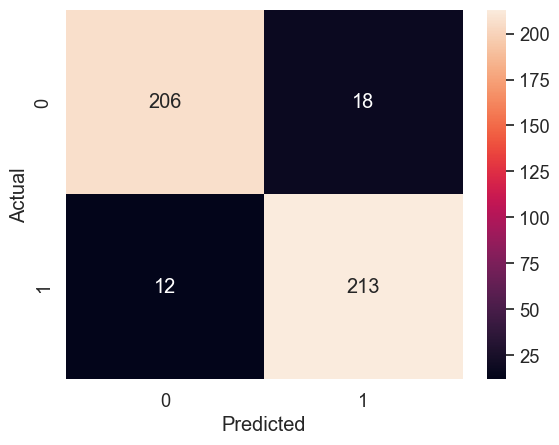

In [33]:
sns.heatmap(cm, annot=True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [34]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       224
           1       0.92      0.95      0.93       225

    accuracy                           0.93       449
   macro avg       0.93      0.93      0.93       449
weighted avg       0.93      0.93      0.93       449



## Inference
<a class="anchor" id="8"></a>
[Table of Contents](#0.1)

In [35]:
# Actual real examples
reviews = [
    'Sathish, You will be hired at managerial roles in top companies',
    'Citrusbug Technolabs is hiring for AI/ML Engineer + 14 new Fresher Data Science jobs',
    'Job opportunity from Wipro just for You!',
    'Dear Congratulations - Get Your Job Offer Letter @ Cognizant',
    'Practice Coding with A Very Big Sum'
]

# Detection of examples
model.predict(reviews)

1/1 [==============================] - 1s 786ms/step


array([[0.8626714 ],
       [0.5379645 ],
       [0.20435609],
       [0.5407413 ],
       [0.14179212]], dtype=float32)

## Deployment
<a class="anchor" id="9"></a>
[Table of Contents](#0.1)

In [36]:
# Save the entire model to a HDF5 file
model.save('Spam Detector.h5')


## References
<a class="anchor" id="10"></a>
[Table of Contents](#0.1)

`www.google.com`  `www.stackoverflow.com`  `www.tensorflowhub.com`  `www.geeksforgeeks.com`  `www.youtube.com`